In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('processed data/fe_missForest_data.csv')

In [54]:
df = pd.read_csv('processed data/missForest_data.csv')

### median dang la tot nhat

In [3]:
df = pd.read_csv('processed data/median_data.csv')

In [2]:
X = df.drop(['overall_rating'], axis=1)
y = df['overall_rating']

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=42)

In [4]:
import pandas as pd
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split

# Tách dữ liệu thành biến mục tiêu và các thuộc tính đầu vào
y = df['overall_rating']  # Biến mục tiêu
X = df.drop(columns=['overall_rating'])  # Các thuộc tính đầu vào
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=42)

# Áp dụng Target Encoding cho cột 'nationality'
target_encoder = TargetEncoder()
X_train['nationality_encoded'] = target_encoder.fit_transform(X_train['nationality'], y_train)
X_test['nationality_encoded'] = target_encoder.transform(X_test['nationality'])

# Xóa cột 'nationality' gốc nếu không cần thiết
X_train.drop(columns=['nationality'], inplace=True)
X_test.drop(columns=['nationality'], inplace=True)

print("Dữ liệu huấn luyện sau khi mã hóa:")
X_train.head()


Dữ liệu huấn luyện sau khi mã hóa:


,age,height_cm,weight_kgs,potential,preferred_foot,weak_foot(1-5),skill_moves(1-5),crossing,finishing,heading_accuracy,...,positions_LB,positions_LM,positions_LW,positions_LWB,positions_RB,positions_RM,positions_RW,positions_RWB,positions_ST,nationality_encoded
15634,31,182.880000,77.1,73,0,4,3,64,73,58,...,0,0,1,0,0,0,0,0,1,68.070064
8147,20,182.102830,78.0,78,0,3,3,44,58,45,...,0,0,0,0,0,0,0,0,0,69.779778
13167,23,181.366882,73.0,77,0,3,3,64,47,56,...,0,0,0,0,1,0,0,0,0,65.710351
10766,27,190.500000,76.2,67,0,3,2,53,38,60,...,0,0,0,0,0,0,0,0,0,63.675918
15695,24,182.880000,76.2,78,1,4,3,68,62,57,...,0,0,0,0,0,0,0,0,0,71.076067


# Train Random Forest với các tham số mặc định

In [5]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [6]:
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

## Đánh giá model RF (tham số mặc định)

In [7]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_model(y_train, y_train_pred, y_test, y_pred):
    print('Train Set:')
    print(f'MSE: {mean_squared_error(y_train, y_train_pred):.3f}')
    print(f'MAE: {mean_absolute_error(y_train, y_train_pred):.3f}')
    print(f'R2: {r2_score(y_train, y_train_pred):.3f}')

    print()

    print('Test Set:')
    print(f'MSE: {mean_squared_error(y_test, y_pred):.3f}')
    print(f'MAE: {mean_absolute_error(y_test, y_pred):.3f}')
    print(f'R2: {r2_score(y_test, y_pred):.3f}')

## Hold out

In [8]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

evaluate_model(y_train, y_train_pred, y_test, y_test_pred)

Train Set:
MSE: 0.033
MAE: 0.103
R2: 0.999

Test Set:
MSE: 0.247
MAE: 0.277
R2: 0.995


In [83]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print('Training Set:')
print('MAE:', mean_absolute_error(y_train, y_train_pred))
print('MSE:', mean_squared_error(y_train, y_train_pred))
print('R2 score:', r2_score(y_train, y_train_pred))

print()

print('Test Set:')
print('MAE:', mean_absolute_error(y_test, y_test_pred))
print('MSE:', mean_squared_error(y_test, y_test_pred))
print('R2 score:', r2_score(y_test, y_test_pred))

Training Set:
MAE: 0.10257188231360778
MSE: 0.03313625041792045
R2 score: 0.999317267857216

Test Set:
MAE: 0.2776065518970418
MSE: 0.24965348487380912
R2 score: 0.9947846872098068


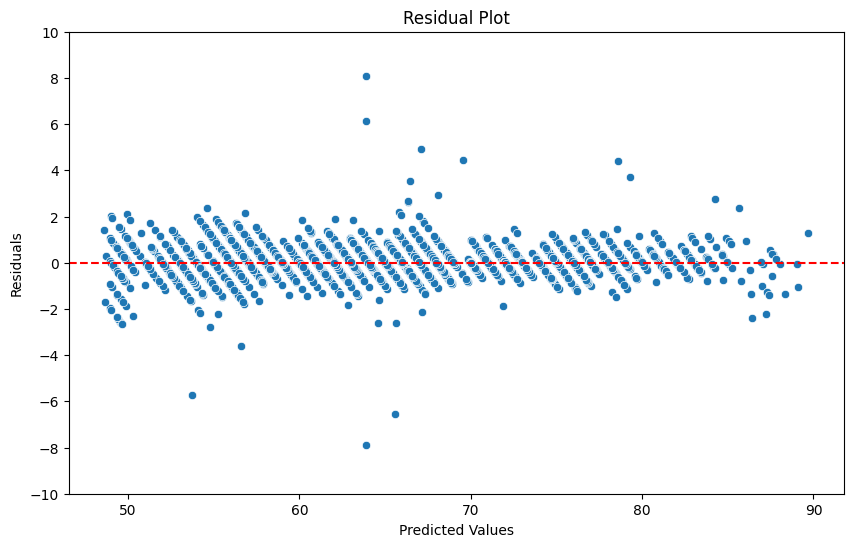

In [ ]:
residuals = y_test - y_test_pred
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test_pred, y=residuals)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.yticks(np.arange(-10, 11, 2))  # Đặt các độ chia cụ thể ở trục y từ -10 đến 10, mỗi độ chia cách nhau 2 đơn vị
plt.show()

## Cross validation

In [41]:
X['nationality_encoded'] = target_encoder.transform(X['nationality'])
X.drop(columns=['nationality'], inplace=True)

In [42]:
from sklearn.model_selection import cross_val_score

# Định nghĩa số lượng folds cho cross-validation
cv = 10

# Sử dụng cross_val_score để tính toán R^2 score
r2_scores = cross_val_score(rf, X, y, cv=cv, scoring='r2', n_jobs=-1)
print(f"R^2 scores cho {cv}-fold cross-validation: {r2_scores}")
print(f"R^2 trung bình: {r2_scores.mean():.3f} ± {r2_scores.std():.3f}")
print()

# Sử dụng cross_val_score để tính toán MSE (sử dụng scoring 'neg_mean_squared_error')
mse_scores = cross_val_score(rf, X, y, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
# Chuyển đổi MSE về giá trị dương
mse_scores = -mse_scores
print(f"MSE cho {cv}-fold cross-validation: {mse_scores}")
print(f"MSE trung bình: {mse_scores.mean():.3f}" + u"\u00B1" + f" {mse_scores.std():.3f}")
print()

# Đánh giá Mean Absolute Error (MAE)
mae_scores = cross_val_score(rf, X, y, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1)
mae_scores = -mae_scores
print(f"MAE cho {cv}-fold cross-validation: {mae_scores}")
print(f"MAE trung bình: {mae_scores.mean():.3f} ± {mae_scores.std():.3f}")

R^2 scores cho 10-fold cross-validation: [0.98840355 0.94796365 0.69188755 0.81717029 0.78627372 0.45610915
 0.4739049  0.62628196 0.80418412 0.95405467]
R^2 trung bình: 0.755 ± 0.181

MSE cho 10-fold cross-validation: [0.18446507 0.17614368 5.37660117 0.61516557 0.20959315 0.27874713
 0.25100028 0.23396132 0.20696577 0.54072497]
MSE trung bình: 0.807± 1.530

MAE cho 10-fold cross-validation: [0.2135376  0.24415042 1.4845961  0.557961   0.31649582 0.35166017
 0.3137883  0.25953177 0.20393534 0.4432107 ]
MAE trung bình: 0.439 ± 0.364


# Thử tối ưu các tham số trong RF

In [15]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 8, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='r2')
grid_search.fit(X, y)
print("Best parameters found: ", grid_search.best_params_)


Best parameters found:  {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


In [16]:
rf = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_leaf=1, min_samples_split=5, random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, min_samples_split=5, random_state=42)

In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print('Training Set:')
print('MAE:', mean_absolute_error(y_train, y_train_pred))
print('MSE:', mean_squared_error(y_train, y_train_pred))
print('R2 score:', r2_score(y_train, y_train_pred))

print()

print('Test Set:')
print('MAE:', mean_absolute_error(y_test, y_test_pred))
print('MSE:', mean_squared_error(y_test, y_test_pred))
print('R2 score:', r2_score(y_test, y_test_pred))

Training Set:
MAE: 0.102755767301906
MSE: 0.03314534436643265
R2 score: 0.999317080487466

Test Set:
MAE: 0.27737422697643344
MSE: 0.24871644659869635
R2 score: 0.9948042621326386
